In [1]:
import os

In [2]:
import os

# Data manipulations libraries
import pandas as pd
import numpy as np
 
# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
 
# Machine learning imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
 
# Misc
import joblib

In [3]:
if not os.path.isdir("data"):
    !mkdir data
    %cd data
    !kaggle competitions download -c bluebook-for-bulldozers
    !unzip bluebook-for-bulldozers.zip
    !rm *.zip *.7z
    %cd ..

In [4]:
# INPUT_PATH = "../input/bluebook-for-bulldozers/"
# OUTPUT_PATH = "/kaggle/working"
INPUT_PATH = "./data/"
OUTPUT_PATH = "./data/"

In [5]:
# This is a utility function to display all columns and rows of a dataframe.
def display_all(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)

# Problem Definition

## 🚜 Predicting the Sale Price of Bulldozers using Machine Learning 🚜

![Competition image](https://storage.googleapis.com/kaggle-competitions/kaggle/3316/media/bulldozer.jpg)

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

Fast Iron is creating a "blue book for bull dozers," for customers to value what their heavy equipment fleet is worth at auction.

## About Fast Iron
This competition was launched under the [Kaggle Startup Program](https://medium.com/kaggle-blog). If you're a startup with a predictive modelling challenge, please apply!

# What data do we have?

For this competition, you are predicting the sale price of bulldozers sold at auctions.

The data for this competition is split into three parts:

* **Train.csv** is the training set, which contains data through the end of 2011.
* **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* `SalesID`: the unique identifier of the sale
* `MachineID`: the unique identifier of a machine.  A machine can be sold multiple times
* `saleprice`: what the machine sold for at auction (only provided in train.csv)
* `saledate`: the date of the sale

There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with `machine configuration` in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.

The **machine_appendix.csv** file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).

In [6]:
# Load TrainAndValid.csv, parsing saledate as datetime
train_df = pd.read_csv(INPUT_PATH + "TrainAndValid.csv",
                       low_memory=False,
                       parse_dates=["saledate"])
train_df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


Also, `SalePrice` is the feature that we want to predict (a.k.a *dependent variable*).

In [7]:
# Print information about the dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

We have a mix of **numerical** and **string** features. Also, a lot of the features (machine configuration, mainly) does have missing values.

## Target variable analysis
Let's check the `SalePrice` distribution.

/tmp/ipykernel_29836/1517366479.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.SalePrice, label="SalePrice", bins=50, ax=ax0, kde=True)


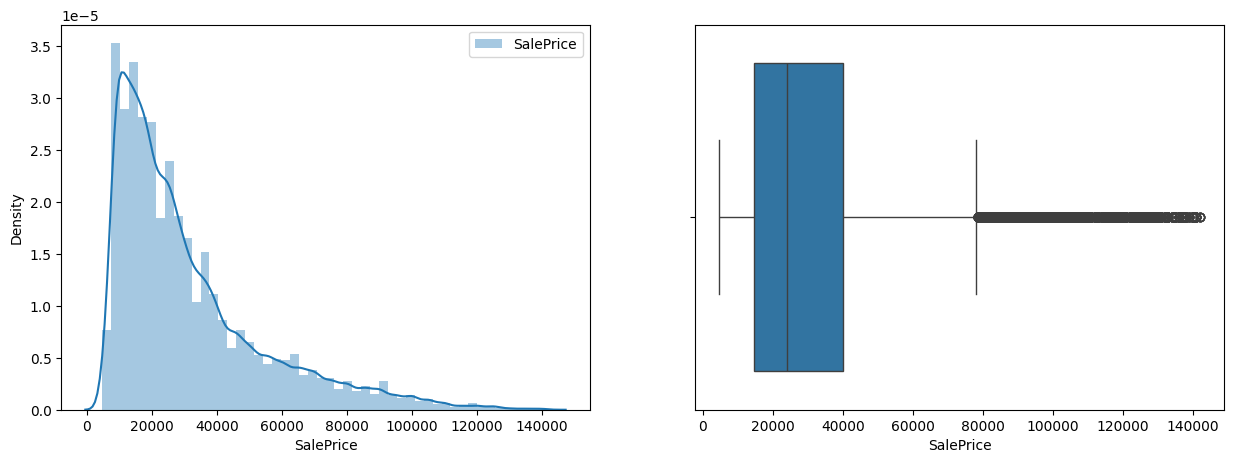

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(train_df.SalePrice, label="SalePrice", bins=50, ax=ax0, kde=True)
ax0.legend()
sns.boxplot(x=train_df.SalePrice, ax=ax1)
plt.show();

The high positive skewness presented by the `SalePrice` distribution indicates that in the majority of the sales were made with prices lower than the mean sale price. This is evidenced by the box plot of the distribution.

## Feature correlation analysis

We'll look into the correlation between features and try to identify which ones have high incluence on the target variable.

### Numerical features

In [9]:
# Describing the numerical data.
desc_df = train_df.describe().T

# Add more useful information
desc_df["% non-null"] = desc_df["count"] / len(train_df)

desc_df

,count,mean,min,25%,50%,75%,max,std,% non-null
SalesID,412698.0,2011161.16364,1139246.0,1421897.75,1645852.5,2261012.5,6333349.0,1080067.724498,1.0
SalePrice,412698.0,31215.181414,4750.0,14500.0,24000.0,40000.0,142000.0,23141.743695,1.0
MachineID,412698.0,1230061.436646,0.0,1088593.25,1284397.0,1478079.25,2486330.0,453953.25795,1.0
ModelID,412698.0,6947.201828,28.0,3261.0,4605.0,8899.0,37198.0,6280.824982,1.0
datasource,412698.0,135.169361,121.0,132.0,132.0,136.0,173.0,9.646749,1.0
auctioneerID,392562.0,6.585268,0.0,1.0,2.0,4.0,99.0,17.158409,0.951209
YearMade,412698.0,1899.049637,1000.0,1985.0,1995.0,2001.0,2014.0,292.190243,1.0
MachineHoursCurrentMeter,147504.0,3522.988285,0.0,0.0,0.0,3209.0,2483300.0,27169.92865,0.357414
saledate,412698,2004-10-19 01:54:17.182733952,1989-01-17 00:00:00,2000-12-06 00:00:00,2006-06-28 00:00:00,2009-05-28 00:00:00,2012-04-28 00:00:00,NaN,1.0


The overall of numerical features is present in all entries, excluding `auctioneerID` and `MachineHoursCurrentMeter` (which is absent in 50% of the dataset).

Let's check the feature correlations.

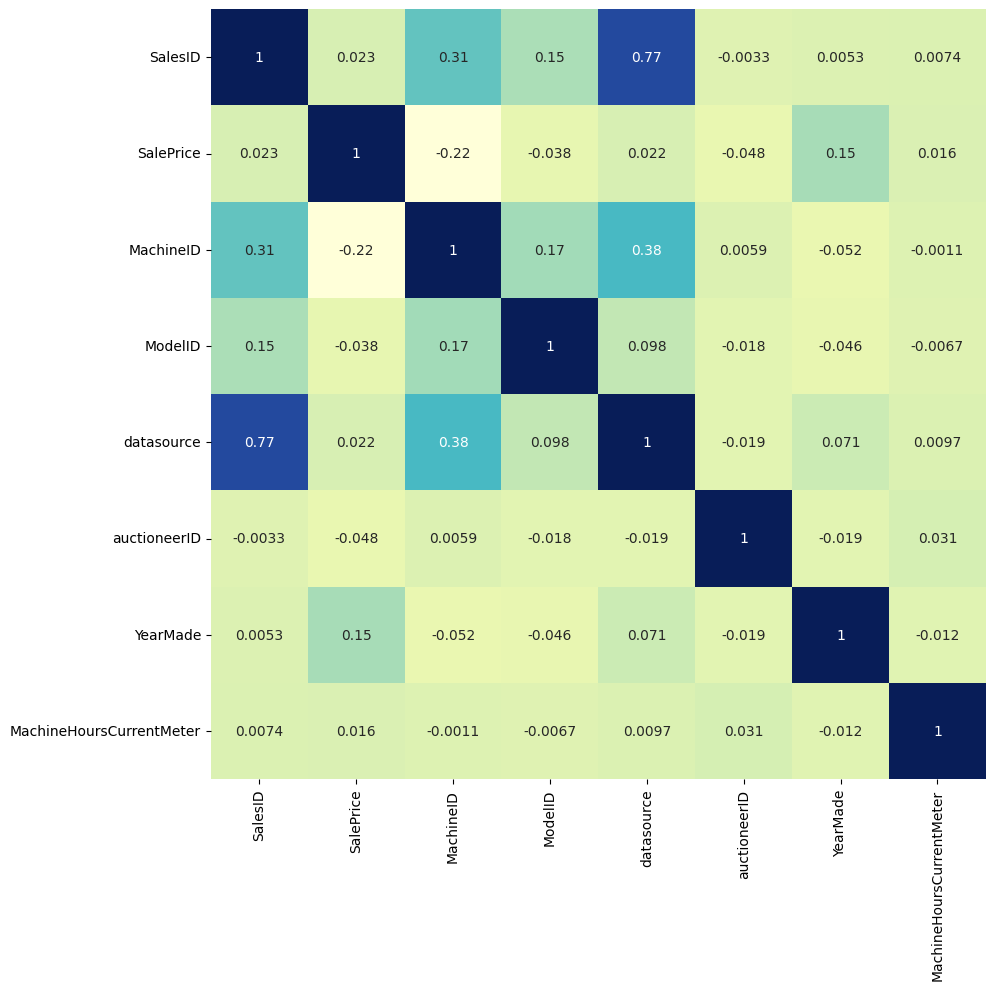

In [10]:
# Ploting feature correlation matrix (only numerical features).
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train_df.select_dtypes(include="number").corr(), annot=True, cmap="YlGnBu", cbar=False, ax=ax)
plt.show()

The only features that have significant correlation with `SalePrice` are `YearMade` and `MachineID`, so we'll investigate them more deeply.

#### YearMade

`YearMade` indicates the registered `year of manufactoring` of the auctioned machine. Let's check the distribution of the sales and mean prices of each year.

/tmp/ipykernel_29836/32424198.py:4: UserWarning: 
The palette list has fewer values (6) than needed (73) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x="YearMade",
/tmp/ipykernel_29836/32424198.py:13: UserWarning: 
The palette list has fewer values (6) than needed (73) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x="YearMade",


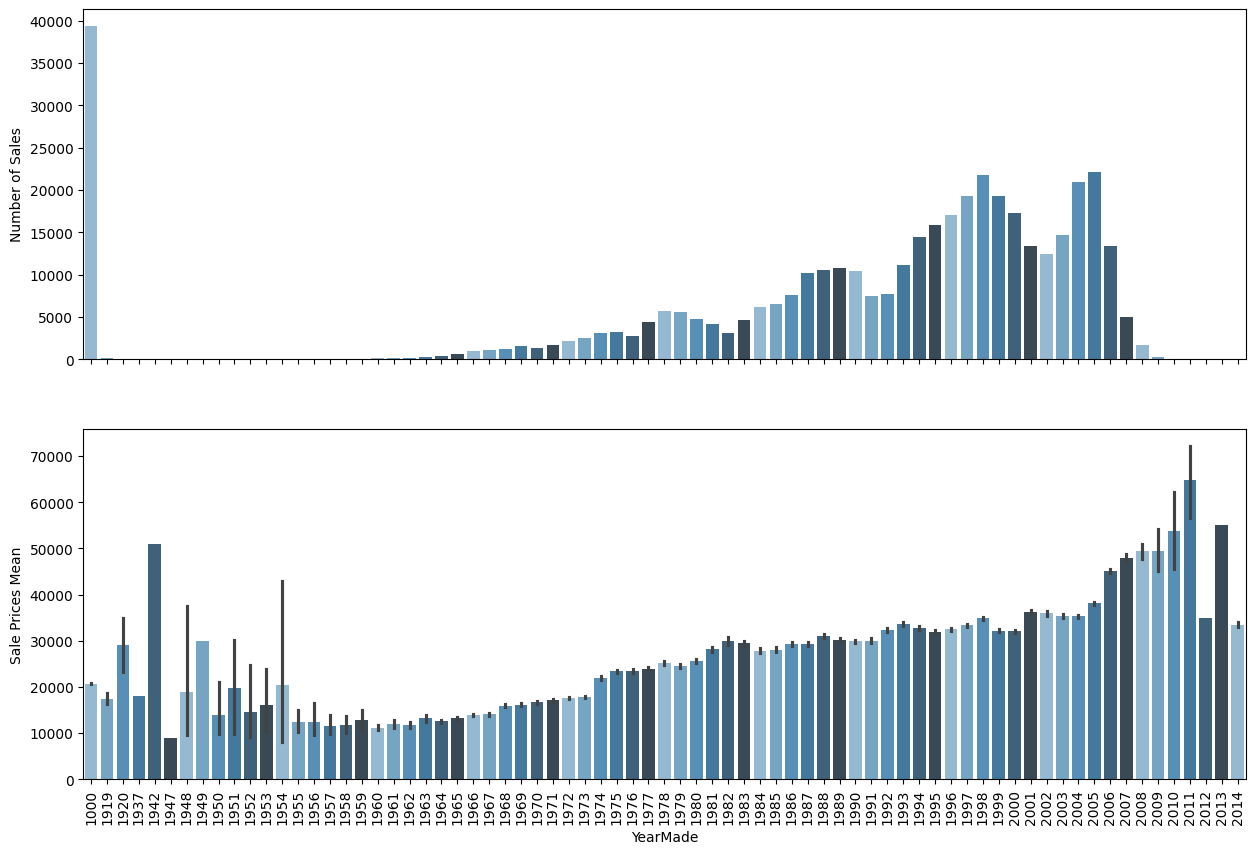

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 10))

# Plotting the sell count for each year
sns.countplot(x="YearMade",
              data=train_df,
              palette=sns.color_palette("Blues_d"),
              hue="YearMade",
              legend=False,
              ax=ax0)
ax0.set_ylabel("Number of Sales")

# Plotting the mean price for each year
sns.barplot(x="YearMade",
            y="SalePrice",
            data=train_df,
            palette=sns.color_palette("Blues_d"),
            hue="YearMade",
            legend=False,
            ax=ax1)
ax1.set_ylabel("Sale Prices Mean")

plt.xticks(rotation=90)
plt.show()

Year 1000 concentrates a high amount of manufactured machines. It's not clear if it's data collection error or just a placeholder for an unregistered year, so we'll just leave it as it is.

Aside from that, from the first plot we can see most of the auctioned machines were made around years 1998 and 2005, with few machines made in years after 2008.

Distribution of prices per year of manufactoring  is as expected. Newer generally machines cost higher than the old ones, with few exceptions.

#### MachineID

The `MachineID` feature denotes a identifier for a particular machine. Machines may have multiple sales, so we can expect same values in some entries. Let's check for unique values.

In [12]:
# Print the rate of unique values for MachineID
n_uniques = len(train_df.MachineID.unique())
uniques_rate = n_uniques / len(train_df)
print(f"Number of unique MachineIDs: {n_uniques} -- Rate of uniques: {uniques_rate}")

Number of unique MachineIDs: 348808 -- Rate of uniques: 0.845189460574076


OK! `MachineID` has *high cardinality*, so it's unlikely that its distribution will make some sense.

Let's plot a scatter plot of the `SalePrice` by `MachineID`. To support our understanding, we'll use the information from `datasource`, a feature that have a significant correlation with `MachineID`, for the plotting.

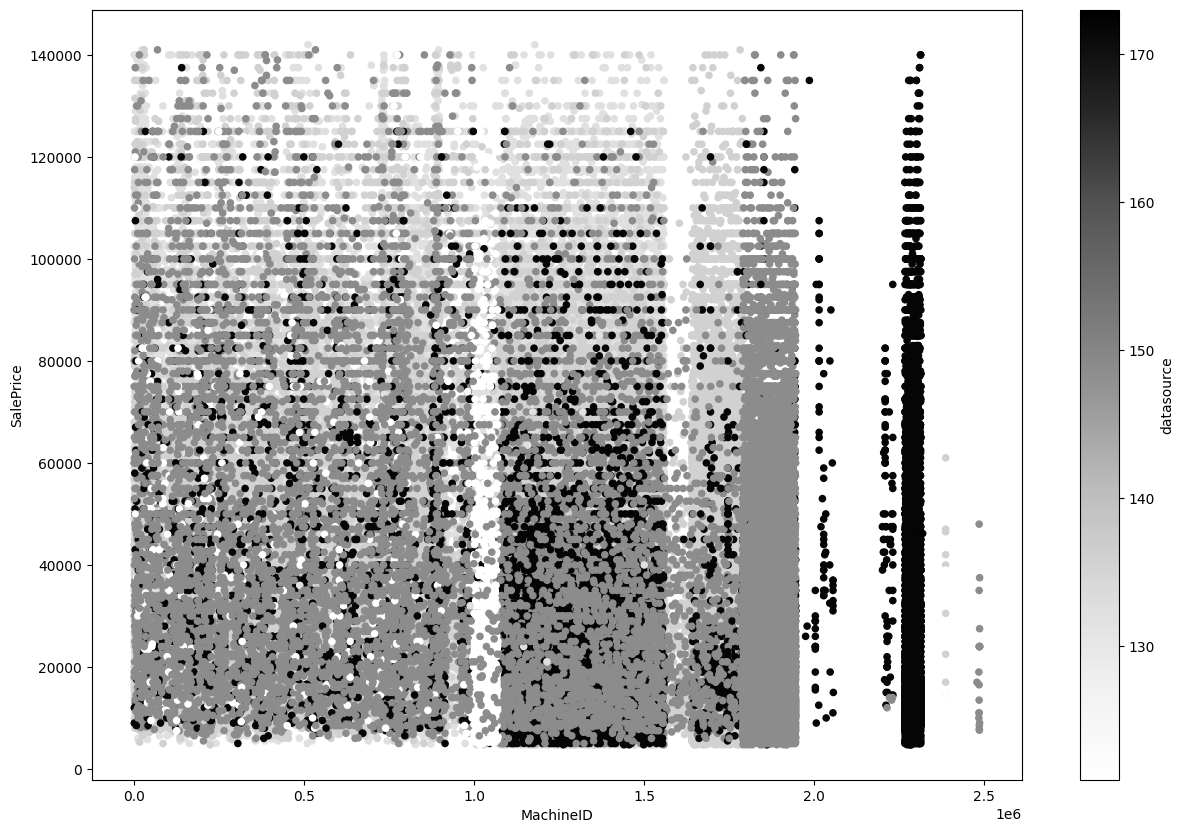

In [13]:
train_df.plot.scatter(x="MachineID", y="SalePrice", c="datasource", figsize=(15, 10));

At first, we can't draw any assumption from this distribution aside that the majority of seliing prices are located at the lower part of the plotting, indicating that much of the prices are below the mean price as we have seem before. Also, it seems that some data sources are specialized at the reporting of specific machines.

### Non-numerical features

In [14]:
# Describe non-numerical features
desc_df = train_df.describe(include="O").T

# Add more useful information.
desc_df["% non-null"] = desc_df["count"] / len(train_df)

desc_df

,count,unique,top,freq,% non-null
UsageBand,73670,3,Medium,35832,0.178508
fiModelDesc,412698,5059,310G,5348,1.0
fiBaseModel,412698,1961,580,20179,1.0
fiSecondaryDesc,271971,177,C,44431,0.659007
fiModelSeries,58667,123,II,13770,0.142155
fiModelDescriptor,74816,140,L,16464,0.181285
ProductSize,196093,6,Medium,64342,0.475149
fiProductClassDesc,412698,74,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,57542,1.0
state,412698,53,Florida,67320,1.0
ProductGroup,412698,6,TEX,104230,1.0


Of all non-numerical features, only 6 of them are complete. Their majority are even not present in 50% of the data, so it may be difficult to find a correlation between any of them and `SalePrice`. But it doesn't mean that we'll justo drop them.

For example, lets take a look at `Blade_Extension` feature.

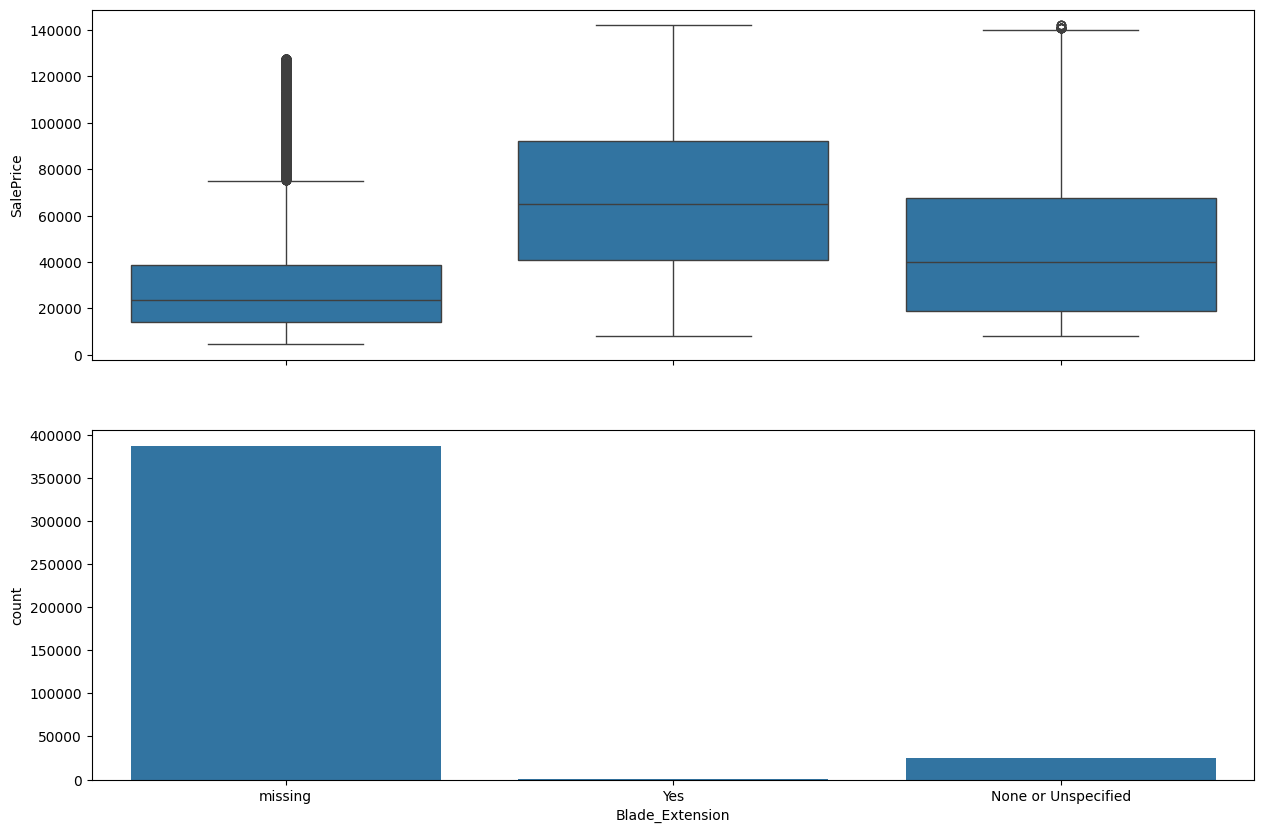

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 10))

# We added the missing values as as separate class for ilustration purposes.
plt_data = train_df.fillna({"Blade_Extension": "missing"})

# Plot the SalePrice distribution per class. 
sns.boxplot(x="Blade_Extension", y="SalePrice", data=plt_data, ax=ax0)
ax0.set(xlabel="")

# Plot the class counts.
sns.countplot(x="Blade_Extension", data=plt_data, ax=ax1)

plt.show()

As we can see, the class information doesn't give us any valuable information, as the classes distributions doesn't differ from each order signicantly. But the lack of class specification, by itself, seemms to be imbued with some predictive information. Our feature engineering will have to consider this kind of information.

# What defines success?

The evaluation metric for this competition is the **RMSLE** (*root mean squared log error*) between the actual and predicted auction prices.

$$
RMSLE = \sqrt{\frac{1}{n} \sum_{i = n}^n (log(predicted_i + 1) - log(actual_i - 1)^2}
$$

Although Scikit-Learn doesn't have a default implementation of this metric, the implementation is straight forward:

In [16]:
# Implementation of RMSLE.
def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Sample submission files can be downloaded from the data page. Submission files should be formatted as follows:

* Have a header: "`SalesID`,`SalePrice`"
* Contain two columns
    * `SalesID`: SalesID for the validation set in sorted order
    * `SalePrice`: Your predicted price of the sale

# Feature Engineering?

## Extracting information from "saledate"

The `saledate` feature informs the **datatime** of the sale of each entry onf the dataset. This type of feature is known as *Time-series* data, and all data scientists will agree that this is one of the most important data types for a in the development of machine learning models.

We'll extract as many as possible of information that this feature provides.

In [17]:
def add_date_parts(df):
    saledate = df.saledate

    df["sale_day"] = saledate.dt.day
    df["sale_month"] = saledate.dt.month
    df["sale_quarter"] = saledate.dt.quarter
    df["sale_year"] = saledate.dt.year
    df["sale_dayofweek"] = saledate.dt.dayofweek
    df["sale_dayofyear"] = saledate.dt.dayofyear
    df["sale_weekofyear"] = saledate.dt.isocalendar().week
    df["sale_is_month_start"] = saledate.dt.is_month_start
    df["sale_is_month_end"] = saledate.dt.is_month_end
    df["sale_is_quarter_start"] = saledate.dt.is_quarter_start
    df["sale_is_quarter_end"] = saledate.dt.is_quarter_end
    df["sale_is_year_start"] = saledate.dt.is_year_start
    df["sale_is_year_end"] = saledate.dt.is_year_end

    # Get rid of "saledate" column
    df.drop("saledate", axis=1, inplace=True)
    
    return df

In [18]:
train_df = add_date_parts(train_df)
display_all(train_df.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


## Downcast

We'll downcast the Dataframe to reduce the amount of memory used and speed up the operations that we'll perform later.

* **Numerical Columns:** Depending on your environment, pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.
Here are the different subtypes you can use:  
`int8` / `uint8` : consumes 1 byte of memory, range between -128/127 or 0/255  
`bool` : consumes 1 byte, true or false  
`float16` / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535  
`float32` / `int32` / `uint32` : consumes 4 bytes of memory, range between -2147483648 and 2147483647  
`float64` / `int64` / `uint64`: consumes 8 bytes of memory  
If one of your column has values between 1 and 10 for example, you will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column!


* **Categorical Columns:** Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.

In [19]:
def downcast(df):
    """
    Downcasts the columns of a Dataframe in order to save memory
    """
    df_copy = df.copy()
    
    for nm, col in df_copy.items():
        if pd.api.types.is_integer_dtype(col):
            col_min, col_max = col.min(), col.max()
            if (col_min > np.iinfo(np.int8).min
                    and col_max < np.iinfo(np.int8).max):
                df_copy[nm] = col.astype(np.int8)
            elif (col_min > np.iinfo(np.int16).min
                  and col_max < np.iinfo(np.int16).max):
                df_copy[nm] = col.astype(np.int16)
            elif (col_min > np.iinfo(np.int32).min
                  and col_max < np.iinfo(np.int32).max):
                df_copy[nm] = col.astype(np.int32)
            else:
                df_copy[nm] = cols.astype(np.int64)
        elif pd.api.types.is_float_dtype(col):
            col_min, col_max = col.min(), col.max()
            #-----------------------------------------------------------
            # In pandas stable, half floats (float16) is not implemented
            #-----------------------------------------------------------
            # if (col_min > np.finfo(np.float16).min
            #         and col_max < np.finfo(np.float16).max):
            #     df_copy[nm] = col.astype(np.float16)
            # elif (col_min > np.finfo(np.float32).min
            #-----------------------------------------------------------
            if (col_min > np.finfo(np.float32).min
                  and col_max < np.finfo(np.float32).max):
                df_copy[nm] = col.astype(np.float32)
            else:
                df_copy[nm] = cols.astype(np.float64)
        elif pd.api.types.is_object_dtype(col):
            df_copy[nm] = col.astype("category")
            
    return df_copy

In [20]:
old_memory_usage = train_df.memory_usage(index=True, deep=True).sum()

In [21]:
train_df = downcast(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 65 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int32   
 1   SalePrice                 412698 non-null  float32 
 2   MachineID                 412698 non-null  int32   
 3   ModelID                   412698 non-null  int32   
 4   datasource                412698 non-null  int16   
 5   auctioneerID              392562 non-null  float32 
 6   YearMade                  412698 non-null  int16   
 7   MachineHoursCurrentMeter  147504 non-null  float32 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [22]:
new_memory_usage = train_df.memory_usage(index=True, deep=True).sum()

memory_gain_ration = new_memory_usage / old_memory_usage
print(f"Memory usage before/after downcasting: {old_memory_usage} / {new_memory_usage} -- Memory gain: {((old_memory_usage - new_memory_usage) / old_memory_usage * 100):.2f}%")

Memory usage before/after downcasting: 863235344 / 38265625 -- Memory gain: 95.57%


The processed dataset now has less than 5% of the original size in memory. A thanks from our computers.

Also, all object type features were transformed into categories

In [23]:
train_df.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [24]:
train_df.state.cat.codes

0          0
1         32
2         31
3         43
4         31
          ..
412693    43
412694     8
412695     8
412696    43
412697     8
Length: 412698, dtype: int8

# Preprocessing

Before we proceed, we would like to keep the actual state of data, for future rerefences.

In [25]:
train_df.to_feather(OUTPUT_PATH + "TrainAndValid_raw.feather")

In [26]:
train_df = pd.read_feather(OUTPUT_PATH + "TrainAndValid_raw.feather")

## Converting categories to numbers

In [27]:
for nm, col in train_df.items():
    if isinstance(col.dtype, pd.CategoricalDtype):
        # Replace the categorical values with their codes.
        # As the missing values are represented with category code "-1",
        # we add 1 to the codes. So all code values are positive
        train_df[nm] = col.cat.codes + 1

## Filling missing numerical values with the median values of each column

In [28]:
for nm, col in train_df.items():
    # Search column for missing values
    is_missing = pd.isnull(col)
    # Check if column type is numerical
    if pd.api.types.is_numeric_dtype(col) and is_missing.sum():
        # Create a missing values indicator column
        train_df[nm + "_is_missing"] = is_missing
        # Fill missing values
        train_df[nm] = col.fillna(col.median())

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 67 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int32  
 1   SalePrice                            412698 non-null  float32
 2   MachineID                            412698 non-null  int32  
 3   ModelID                              412698 non-null  int32  
 4   datasource                           412698 non-null  int16  
 5   auctioneerID                         412698 non-null  float32
 6   YearMade                             412698 non-null  int16  
 7   MachineHoursCurrentMeter             412698 non-null  float32
 8   UsageBand                            412698 non-null  int8   
 9   fiModelDesc                          412698 non-null  int16  
 10  fiBaseModel                          412698 non-null  int16  
 11  fiSecondaryDe

In [30]:
display_all(train_df.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,2,2,1,1,3
fiModelDesc,963,1745,336,3716,4261


In [31]:
display_all(train_df.isna().sum() / len(train_df))

SalesID                                0.0
SalePrice                              0.0
MachineID                              0.0
ModelID                                0.0
datasource                             0.0
auctioneerID                           0.0
YearMade                               0.0
MachineHoursCurrentMeter               0.0
UsageBand                              0.0
fiModelDesc                            0.0
fiBaseModel                            0.0
fiSecondaryDesc                        0.0
fiModelSeries                          0.0
fiModelDescriptor                      0.0
ProductSize                            0.0
fiProductClassDesc                     0.0
state                                  0.0
ProductGroup                           0.0
ProductGroupDesc                       0.0
Drive_System                           0.0
Enclosure                              0.0
Forks                                  0.0
Pad_Type                               0.0
Ride_Contro

## Saving processed dataset

In [32]:
train_df.to_feather(OUTPUT_PATH + "TrainAndValid_preprocessed.feather")

In [33]:
train_df = pd.read_feather(OUTPUT_PATH + "TrainAndValid_preprocessed.feather")

# Modelling

## Train and Validation sets
We'll split the DataFrame in train and validation sets. Quoting the Kaggle's description of the dataset.

> * **Train.csv** is the training set, which contains data through the end of 2011.
* **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

In [34]:
valid_df = train_df[train_df.sale_year == 2012]
train_df = train_df[train_df.sale_year != 2012]

# Split the sets in independent variables and dependent variables
X_train, y_train = train_df.drop("SalePrice", axis=1), train_df.SalePrice
X_valid, y_valid = valid_df.drop("SalePrice", axis=1), valid_df.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 66), (401125,), (11573, 66), (11573,))

## Evaluation function

Now, we'll build our first model. But first, let's implement and evaluation function, that will compute three performance metrics:

* *Mean Absolute error* (**MAE**)
* *R<sup>2</sup> regression score*
* *Root Mean Squared Logarithmic Error* (**RMSLE**)

In [35]:
def score_model(model):
    """
    Computes the MAE, R2 and RMSLE scores.
    """
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    return {
        "Train MAE": mean_absolute_error(y_train, train_pred),
        "Valid MAE": mean_absolute_error(y_valid, valid_pred),
        "Train R2": r2_score(y_train, train_pred),
        "Valid R2": r2_score(y_valid, valid_pred),
        "Train RMSLE": root_mean_squared_log_error(y_train, train_pred),
        "Valid RMSLE": root_mean_squared_log_error(y_valid, valid_pred),
    }

## Fit a Random Forest Regressor

Now, we'll fit a Random Forest Regressor with default parameters.

In [36]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
 
model.fit(X_train, y_train)
 
model.score(X_valid, y_valid)

0.8724778002955024

In [37]:
# Using our evaluation function
score = score_model(model)
score

{'Train MAE': 1577.7610663010275,
 'Valid MAE': 6131.632558473927,
 'Train R2': 0.9875300380834855,
 'Valid R2': 0.8724778002955024,
 'Train RMSLE': 0.08415064980914491,
 'Valid RMSLE': 0.255176589942664}

Not bad for our first model, and we have not touched the hyperparameters.

But can we do better? Let's check out.

## RandomizedSearchCV

In [38]:
# Grid parameters.
rs_params = {
    "n_estimators": 2 ** np.arange(1, 7, 2) * 10,
    "max_features": [0.3, 0.5, "auto", "sqrt", "log2"],
    "max_depth": np.arange(5, 36, 10),
    "min_samples_leaf": np.arange(1, 7, 2),
    "min_samples_split": np.arange(10, 17, 2),
    "max_samples": [1000]
}
 
# Instantiate  the grid search class
rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rs_params,
                              n_jobs=-1,
                              n_iter=200,
                              verbose=True,
                              random_state=42)
 
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/mnt/3273eabb-9e14-47b4-8ddd-ddb77dddcd30/workspace/DataScienceMiniProjects/BlueBookForBulldozers/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
185 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
142 fits failed with the following error:
Traceback (most recent call last):
  File "/mnt/3273eabb-9e14-47b4-8ddd-ddb77dddcd30/workspace/DataScienceMiniProjects/BlueBookForBulldozers/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/mnt/3273eabb-9e14-47b4-8ddd-ddb77dddcd30/workspace/DataScienceMiniProjects/BlueBookForBulldozers/.venv/lib/python3.10

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': array([ 5, 15, 25, 35]),
                                        'max_features': [0.3, 0.5, 'auto',
                                                         'sqrt', 'log2'],
                                        'max_samples': [1000],
                                        'min_samples_leaf': array([1, 3, 5]),
                                        'min_samples_split': array([10, 12, 14, 16]),
                                        'n_estimators': array([ 20,  80, 320])},
                   random_state=42, verbose=True)

In [39]:
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_samples': 1000,
 'max_features': 0.5,
 'max_depth': 35}

In [40]:
joblib.dump(rs_model, OUTPUT_PATH + "rs_model.bz2", compress=True)

['./data/rs_model.bz2']

In [41]:
rs_model = joblib.load(OUTPUT_PATH + "rs_model.bz2")

Now, let's check how well does the found model is fitted.

In [42]:
%%time
score_model(rs_model)

CPU times: user 1.07 s, sys: 28 ms, total: 1.09 s
Wall time: 1.09 s


{'Train MAE': 8207.30074732873,
 'Valid MAE': 9861.611474643918,
 'Train R2': 0.7222029803044785,
 'Valid R2': 0.7121454489591368,
 'Train RMSLE': 0.36092800994463675,
 'Valid RMSLE': 0.39308267644436035}

## Fit a RandomForest with the best found hyperparameters.

In [43]:
%%time
model = RandomForestRegressor(
    n_estimators=rs_model.best_params_["n_estimators"],
    max_depth=rs_model.best_params_["max_depth"],
    max_features=rs_model.best_params_["max_features"],
    min_samples_leaf=rs_model.best_params_["min_samples_leaf"],
    min_samples_split=rs_model.best_params_["min_samples_split"],
    n_jobs=-1,
    random_state=42
    )

model.fit(X_train, y_train)

CPU times: user 4min 30s, sys: 603 ms, total: 4min 31s
Wall time: 24.2 s


RandomForestRegressor(max_depth=35, max_features=0.5, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=80, n_jobs=-1,
                      random_state=42)

In [44]:
%%time
score_model(model)

CPU times: user 5.89 s, sys: 24.8 ms, total: 5.92 s
Wall time: 610 ms


{'Train MAE': 2841.76078446749,
 'Valid MAE': 5928.560125073275,
 'Train R2': 0.9598034058380531,
 'Valid R2': 0.8817790416374675,
 'Train RMSLE': 0.14224060244695863,
 'Valid RMSLE': 0.24464235676967983}

In [45]:
joblib.dump(model, OUTPUT_PATH + "model.bz2", compress=True)

['./data/model.bz2']

In [46]:
model = joblib.load(OUTPUT_PATH + "model.bz2")

##  Reducing overfitting

The obtained model seems to be overfitted to the training set. By adjusting some parameters we can enforce variation in the estimators (random trees) pertaining to the model, improving its generalization.

During process of RandomSearchCV, some of those parameters were tested, and some of their chosen values are already good:
* **n_estimators:** In general the more trees the less likely the algorithm is to overfit. So try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set.
* **max_features:** This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting.
* **max_depth:** This will reduce the complexity of the learned models, lowering over fitting risk. Try starting small, say 5-10, and increasing you get the best result.
* **min_samples_leaf:** This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.

The discussion about these informations can be found in this stackoverflow thread:
https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

As said before, `n_estimators`, `max_depth` and `min_samples_leaf` parameter values seems good, but the `max_features` value seems strange. According to the *Scikit-Learn* documentation about the *RandomForestClassfier*:

> The number of features to consider when looking for the best split:
- If int, then consider `max_features` features at each split.
- If float, then `max_features` is a fraction and
  `int(max_features * n_features)` features are considered at each
  split.
- If "auto", then `max_features=n_features`.
- If "sqrt", then `max_features=sqrt(n_features)`.
- If "log2", then `max_features=log2(n_features)`.
- If None, then `max_features=n_features`.

So, with value our `auto`, the classifier will use all features for the splits. Let's change these values a bit to see if the predictions can be improved.

In [47]:
# We'll train a classifier that uses only half o features for the splits.
model = RandomForestRegressor(n_estimators=320,
                              max_features=0.5,
                              max_depth=25,
                              min_samples_leaf=3,
                              min_samples_split=10,
                              n_jobs=-1,
                              random_state=42)

In [48]:
%%time
model.fit(X_train, y_train)

CPU times: user 18min 9s, sys: 1.35 s, total: 18min 10s
Wall time: 1min 32s


RandomForestRegressor(max_depth=25, max_features=0.5, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=320, n_jobs=-1,
                      random_state=42)

In [49]:
%%time
score_model(model)

CPU times: user 22.8 s, sys: 84 ms, total: 22.9 s
Wall time: 2.06 s


{'Train MAE': 2889.2803703240274,
 'Valid MAE': 5887.60878715849,
 'Train R2': 0.959129211567868,
 'Valid R2': 0.8834397710543416,
 'Train RMSLE': 0.14457173416284955,
 'Valid RMSLE': 0.24261471693585238}

In [50]:
joblib.dump(model, OUTPUT_PATH + "model_max_features.bz2", compress=True)

['./data/model_max_features.bz2']

In [51]:
model = joblib.load(OUTPUT_PATH + "model_max_features.bz2")

# Preparing for submission

## Pre-processing function

In [52]:
df_raw = pd.read_feather(OUTPUT_PATH + "TrainAndValid_raw.feather")

In [53]:
def adjust_types(df, ref_df):
    df_copy = df.copy()
    
    for nm, col in df_copy.items():
        if isinstance(col.dtype, pd.CategoricalDtype):
            categories = ref_df[nm].cat.categories
            df_copy[nm] = pd.Categorical(col, categories=categories, ordered=True)
        else:
            df_copy[nm] = col.astype(ref_df[nm].dtype)
    
    return df_copy


def preprocess(df, ref_df=None):
    
    df_copy = df.copy()
    
    df_copy = add_date_parts(df_copy)
    
    if ref_df is None:
        df_copy = downcast(df_copy)
    else:
        df_copy = adjust_types(df_copy, ref_df)
    
    for nm, col in df_copy.items():
        is_missing = pd.isnull(col)
        if pd.api.types.is_numeric_dtype(col):
            if ref_df is None:
                if is_missing.sum():
                    df_copy[nm + "_is_missing"] = is_missing
                    # Fill missing values with col median of df_copy
                    df_copy[nm] = col.fillna(col.median())
            else:
                ref_col = ref_df[nm]
                ref_have_missing = pd.isnull(ref_col).sum()
                if ref_have_missing:
                    df_copy[nm + "_is_missing"] = is_missing
                    # Fill missing values with col median of ref_df
                    df_copy[nm] = col.fillna(ref_col.median())
                
        elif isinstance(col.dtype, pd.CategoricalDtype):
            df_copy[nm] = col.cat.codes + 1
    
    return df_copy

## Loading the Testing set

In [54]:
test_df = pd.read_csv(INPUT_PATH + "Test.csv", low_memory=False, parse_dates=["saledate"])
test_df.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


In [55]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

## Pre-process the Testing set

In [56]:
test_df = preprocess(test_df, df_raw)
display_all(test_df.head().T)

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,2,1,3,1,2
fiModelDesc,1071,1726,2509,605,1206
fiBaseModel,326,522,775,197,354


In [57]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 66 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalesID                              12457 non-null  int32  
 1   MachineID                            12457 non-null  int32  
 2   ModelID                              12457 non-null  int32  
 3   datasource                           12457 non-null  int16  
 4   auctioneerID                         12457 non-null  float32
 5   YearMade                             12457 non-null  int16  
 6   MachineHoursCurrentMeter             12457 non-null  float32
 7   UsageBand                            12457 non-null  int8   
 8   fiModelDesc                          12457 non-null  int16  
 9   fiBaseModel                          12457 non-null  int16  
 10  fiSecondaryDesc                      12457 non-null  int16  
 11  fiModelSeries               

## Make predictions on the Testing set.

In [58]:
# Make the predictions
test_preds = model.predict(test_df)

# Prepare the submission Dataframe
submission_df = pd.DataFrame()
submission_df["SalesID"] = test_df["SalesID"]
submission_df["SalesPrice"] = test_preds

display_all(submission_df)

,SalesID,SalesPrice
0,1227829,16832.512246
1,1227844,29919.471147
2,1227847,48852.216024
3,1227848,95521.116645
4,1227863,27433.406371
5,1227870,30567.550106
6,1227871,26865.280507
7,1227879,20182.380143
8,1227880,17141.102159
9,1227881,30225.700229


In [59]:
# Save the predictions file.
submission_df.to_csv("test_predictions.csv")